In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
from tqdm import tqdm, trange

import oagm_utils

from bikebench.benchmarking.public_benchmarking_utils import Benchmarker, get_single_conditionally_valid_sample, ScoreReportDashboard


/home/mileva/mambaforge/envs/bike-bench-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import importlib
importlib.reload(oagm_utils)


def predict(cond_test, scaler, generate_fn, batch_size, D, G, noise_dim):
    
    predictions = []
    #use batch size
    for i in range(0, len(cond_test), batch_size):
        batch = cond_test[i:i + batch_size]
        pred = generate_fn(D, G, batch, noise_dim, device=device)
        pred = scaler.unscale(pred)
        predictions.append(pred)
    predictions = torch.concat(predictions, axis=0)
    return predictions

def get_objective_scales(bench, num_samples=1000):
    with torch.no_grad():
        data_tens = bench.data
        #sample random data
        random_indices = torch.randperm(data_tens.shape[0])[:num_samples]
        data_tens = data_tens[random_indices].to(device)

        random_cond = bench.get_train_conditions(num_samples)
        # Evaluate the sampled points
        eval_scores = bench.evaluate(data_tens, random_cond).cpu()

        # Compute the scales for each objective
        obj_scales = torch.std(eval_scores, dim=0)
        if torch.any(obj_scales == 0):
            print("Warning: Some objectives have zero standard deviation. Setting their scales to 1.0 to avoid division by zero.")
        obj_scales[obj_scales == 0] = 1.0  # Prevent division by zero

        return obj_scales.to(device)

def train_and_score(bench, model="VAE", div_weight=0.25, conditional = True): #329 epochs is 998400 evaluations
    guidance_params = None
    if conditional:
        if model == "VAE" or model == "GAN":
            epochs = 328
        elif model == "DDPM": #CDDPM only calls evaluator if more than halfway denoised
            epochs = 650
        elif model == "DDPM-G": #doesnt call evaluator during training
            epochs = 2000

        epochs = 328 
        scale_probe_samples = 1000 
    else:
        if model == "VAE" or model == "GAN":
            epochs = 309
            generate_per_condition = 600
        elif model == "DDPM": #CDDPM only calls evaluator if more than halfway denoised
            epochs = 600
            generate_per_condition = 600
        elif model == "DDPM-G": #doesnt call evaluator during training
            epochs = 2000
            generate_per_condition = 200 #limit this - each requires many calls during denoising (tradeoff vs. n_guidance)
            guidance_params = {"n_guidance":45, "start_frac":0.5, "power":3.0, "min_gap":1, "alpha_min":0.15, "alpha_max":1.0}
        scale_probe_samples = 1000
        

    data_tens = bench.data
    scaler = oagm_utils.TorchScaler(data_tens)
    scaled_data_tens = scaler.scale(data_tens).to(device)

    obj_scales = get_objective_scales(bench, num_samples=scale_probe_samples) 

    aux_fn = oagm_utils.get_diversity_loss_fn(bench, scaler, obj_scales=obj_scales,
                                                         diversity_weight = div_weight, 
                                                         score_weight = 1.0, 
                                                         constraint_vs_objective_weight = 100, 
                                                         constraint_falloff = 10, 
                                                         dpp_batch = 16,
                                                         device = device)

    noise_dim = 10
    batch_size = 512
    train_params = (batch_size, 0.002, 0.002, noise_dim, epochs, 2, 256)

    def condition_sampler(batch_size, set = 'train', condition_idx = None):
        if set == 'train':
            condition = bench.get_train_conditions(batch_size)
        else:
            if condition_idx is not None:
                condition = bench.get_single_test_condition(condition_idx)
                #expand dims of each value in dict
                for key in condition:
                    condition[key] = condition[key].unsqueeze(0)
            else:
                condition = bench.get_test_conditions()
        emb = condition['Embedding']
        rider = condition['Rider']
        use_case = condition['Use Case']
        
        all = torch.cat((emb, rider, use_case), dim=1)
        return all
        

    D, G, generate_fn = oagm_utils.train_model(scaled_data_tens, model, train_params, aux_fn, condition_sampler, device, guidance_params=guidance_params)


    if conditional:
        cond_test = condition_sampler(None, set='test').to(device)
        predictions = predict(cond_test, scaler, generate_fn, batch_size, D, G, noise_dim).detach()

    if not conditional:
        predictions = []
        for i in trange(100):
            cond_test = condition_sampler(None, set='test', condition_idx = i).to(device)
            cond = cond_test.repeat(generate_per_condition, 1)
            pred = predict(cond, scaler, generate_fn, batch_size, D, G, noise_dim).detach()
            samples = get_single_conditionally_valid_sample(bench, pred, i)
            predictions.append(samples)
        predictions = torch.cat(predictions, dim=0)

    return predictions, D, G


In [ ]:

for masked in [True, False]:
    for conditional in [True, False]:
        model = "VAE" #DDPM, DDPM-G, VAE, GAN
        if model == "VAE":
            div_weight=1.0
        else: 
            div_weight=0.5
        bench = Benchmarker(device=device, masked_constraints=masked, gradient_free=False)
        generated, D, G = train_and_score(bench, model = model, div_weight = div_weight, conditional = conditional)
        main_scores, detailed_scores, all_evaluation_scores = bench.score(generated)
        if masked:
            save_name = f"{model}_masked"
        else:
            save_name = f"{model}"
        if conditional:
            save_name += "_conditional"
        bench.save_results(f"results/benchmark_results/{save_name}")

        #save models to results/models
        model_dir = f"results/models/{save_name}"
        os.makedirs(model_dir, exist_ok=True)
        torch.save(G.state_dict(), os.path.join(model_dir, "G.pt"))
        torch.save(D.state_dict(), os.path.join(model_dir, "D.pt"))
        print(main_scores)

/home/mileva/Documents/Lyle/Bike-Bench-Internal/benchmark_models/oagm_utils.py:673: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).float()
100%|██████████| 100/100 [00:08<00:00, 11.32it/s]
/home/mileva/Documents/Lyle/Bike-Bench-Internal/benchmark_models/oagm_utils.py:673: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).float()


Design Quality ↑ (HV)      0.015722
Constraint Violation ↓       1.0615
Sim. to Data ↓ (MMD)       0.283785
Novelty ↑                 10.117933
Binary Validity ↑            0.4371
Diversity ↓ (DPP)         14.921505
Evaluation Count           996328.0
Conditional?                   True
Masked Constraints?            True
Gradient Free?                False
dtype: object


  9%|▉         | 9/100 [00:00<00:01, 85.34it/s]

Evaluation function called after receiving test conditions; logging as unconditional evaluation!


100%|██████████| 100/100 [00:08<00:00, 11.16it/s]
/home/mileva/Documents/Lyle/Bike-Bench-Internal/benchmark_models/oagm_utils.py:673: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).float()


Design Quality ↑ (HV)      0.014245
Constraint Violation ↓       0.9713
Sim. to Data ↓ (MMD)       0.340551
Novelty ↑                 10.503898
Binary Validity ↑            0.4364
Diversity ↓ (DPP)         14.994894
Evaluation Count           998984.0
Conditional?                  False
Masked Constraints?            True
Gradient Free?                False
dtype: object


100%|██████████| 100/100 [00:09<00:00, 10.33it/s]
/home/mileva/Documents/Lyle/Bike-Bench-Internal/benchmark_models/oagm_utils.py:673: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).float()


Design Quality ↑ (HV)      0.018631
Constraint Violation ↓       0.0014
Sim. to Data ↓ (MMD)       0.347595
Novelty ↑                 10.689225
Binary Validity ↑            0.9986
Diversity ↓ (DPP)         14.970722
Evaluation Count           996328.0
Conditional?                   True
Masked Constraints?           False
Gradient Free?                False
dtype: object


  8%|▊         | 8/100 [00:00<00:01, 70.64it/s]

Evaluation function called after receiving test conditions; logging as unconditional evaluation!


100%|██████████| 100/100 [00:10<00:00,  9.72it/s]

Design Quality ↑ (HV)      0.018111
Constraint Violation ↓          0.0
Sim. to Data ↓ (MMD)       0.300915
Novelty ↑                 10.446804
Binary Validity ↑               1.0
Diversity ↓ (DPP)         14.959956
Evaluation Count           998984.0
Conditional?                  False
Masked Constraints?           False
Gradient Free?                False
dtype: object


/home/mileva/Documents/Lyle/Bike-Bench-Internal/src/bikebench/benchmarking/public_benchmarking_utils.py:284: UserWarning: Dataset: results directory missing (results/benchmark_results/baseline_dataset_conditional), skipping.
  warnings.warn(f"{name}: results directory missing ({d}), skipping.")
/home/mileva/Documents/Lyle/Bike-Bench-Internal/src/bikebench/benchmarking/public_benchmarking_utils.py:284: UserWarning: Dataset masked: results directory missing (results/benchmark_results/baseline_dataset_masked_conditional), skipping.
  warnings.warn(f"{name}: results directory missing ({d}), skipping.")
/home/mileva/Documents/Lyle/Bike-Bench-Internal/src/bikebench/benchmarking/public_benchmarking_utils.py:383: UserWarning: No model_colors provided; using Matplotlib cycle.
  warnings.warn("No model_colors provided; using Matplotlib cycle.")


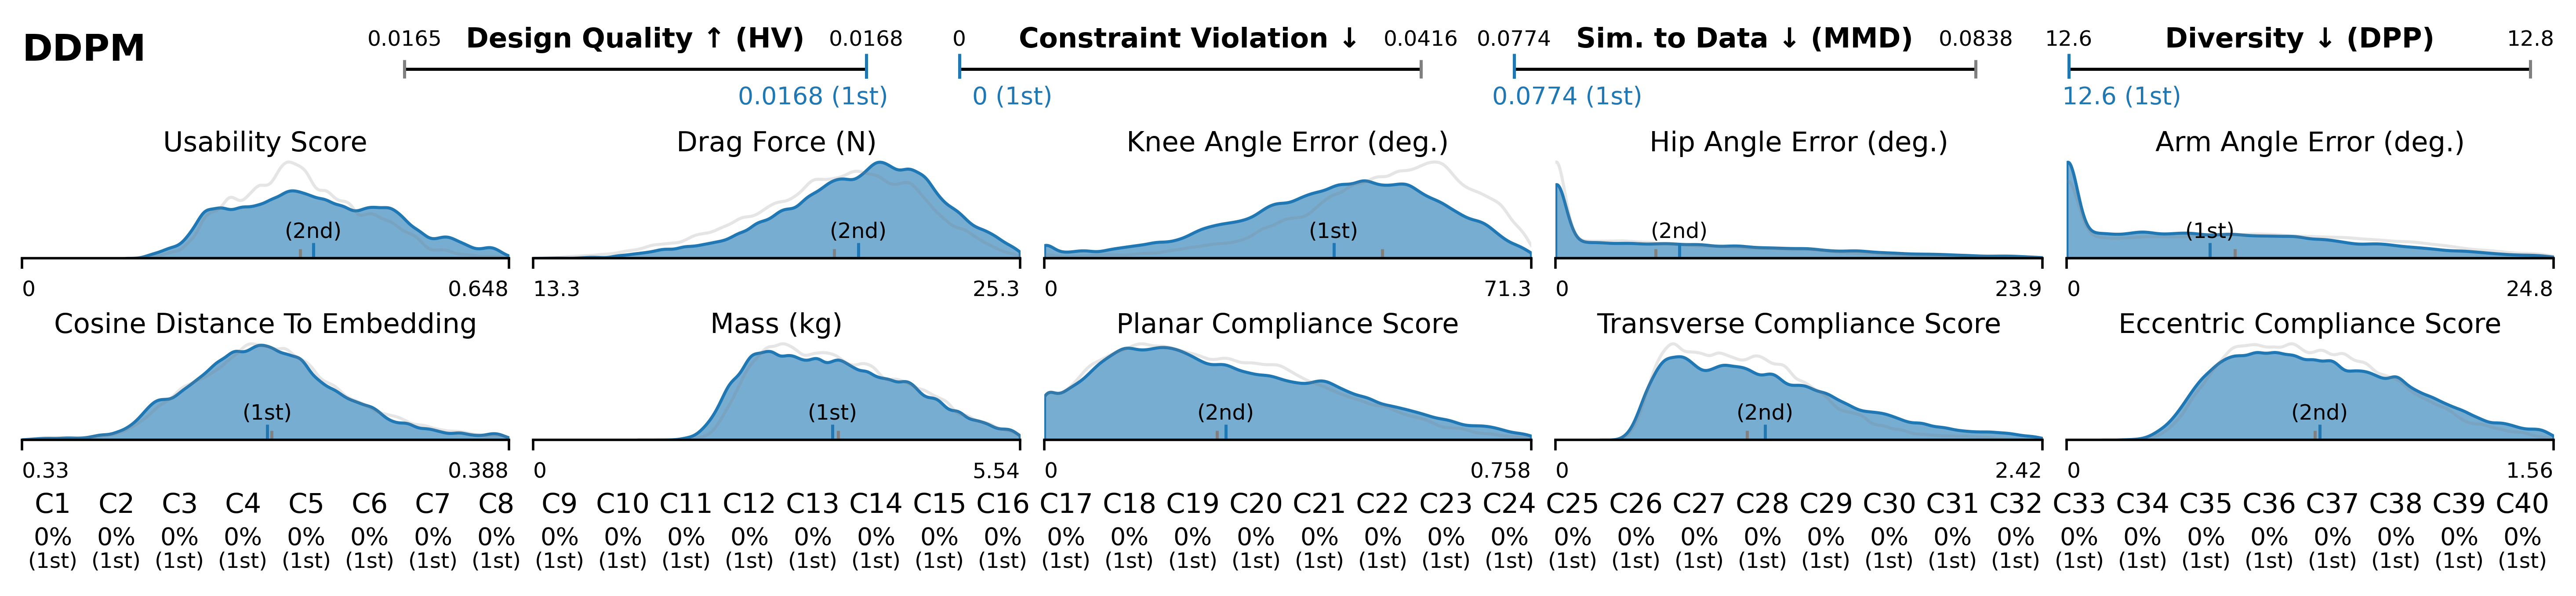

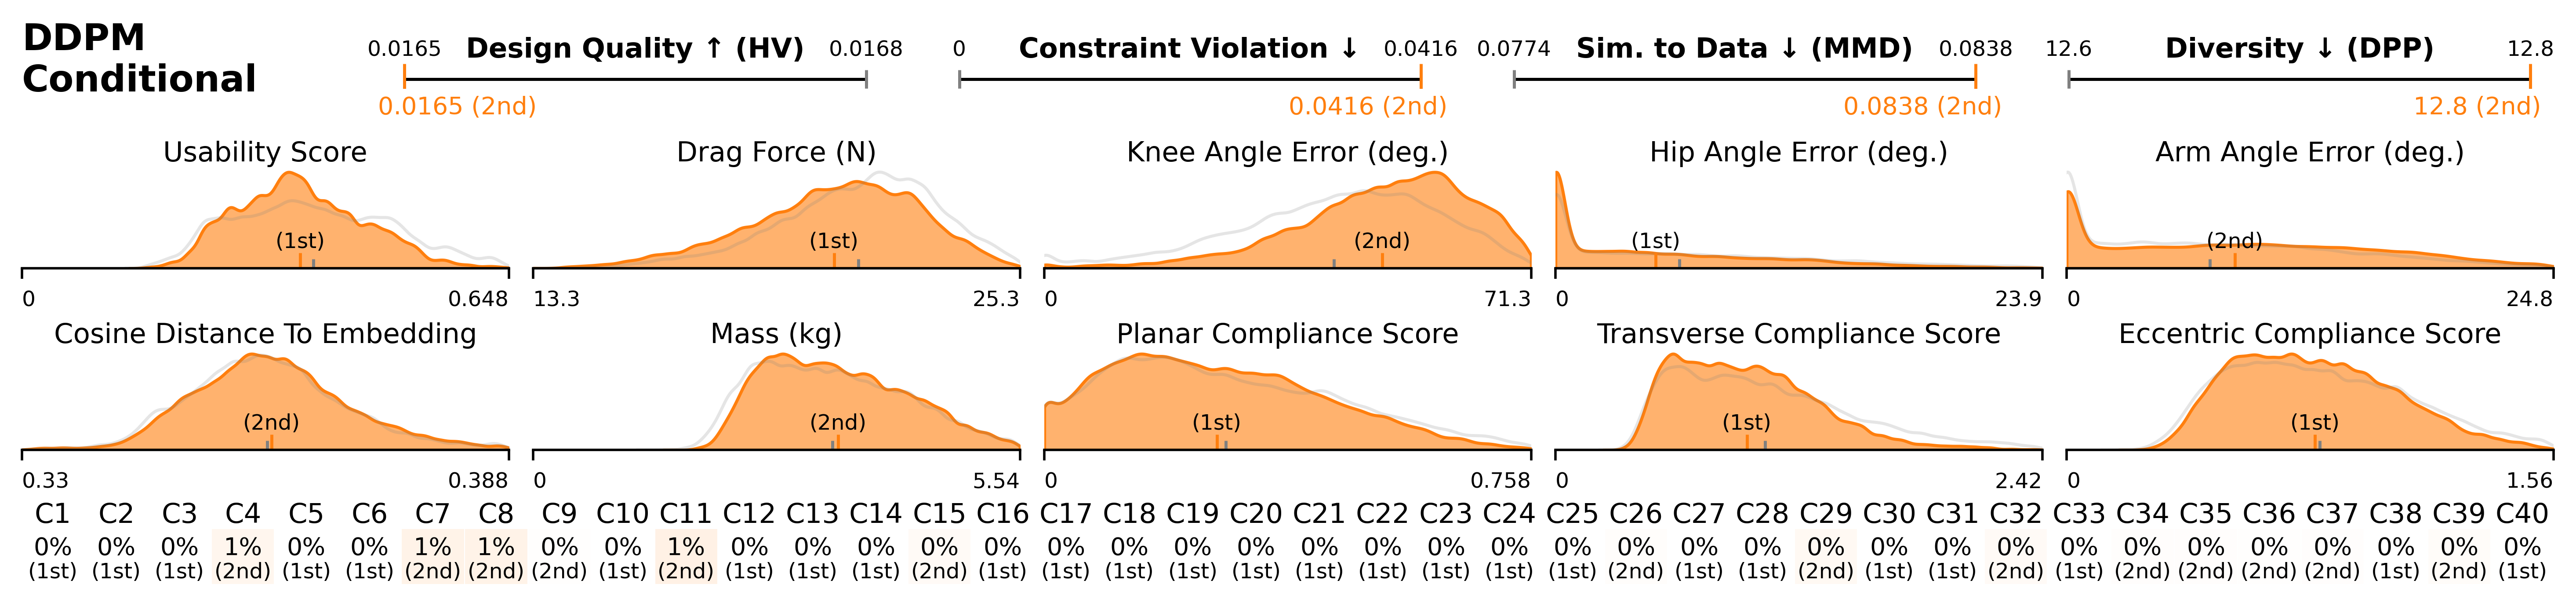

Model 'Dataset' not found in dashboard data. Skipping.
Model 'Dataset masked' not found in dashboard data. Skipping.


In [5]:
filepaths_conditional = {
    "DDPM": "results/benchmark_results/DDPM",
    "DDPM Conditional": "results/benchmark_results/DDPM_conditional",
    "Dataset": "results/benchmark_results/baseline_dataset_conditional",
    "Dataset masked": "results/benchmark_results/baseline_dataset_masked_conditional"
}
dashboard_conditional = ScoreReportDashboard(
    filepaths = filepaths_conditional,
)
for m in filepaths_conditional.keys():
    dashboard_conditional.show_model(m)